<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/OrigAdultInflight1410_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


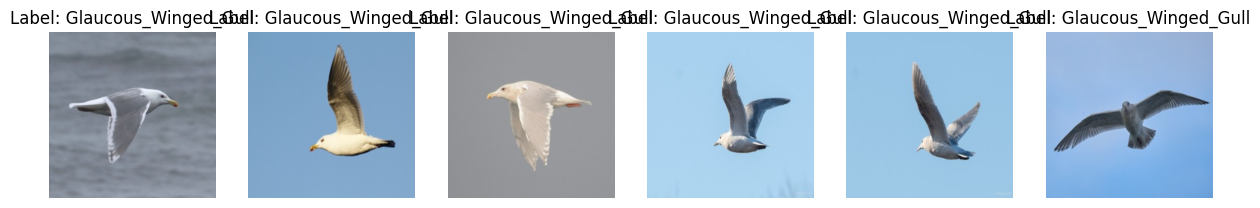

Class distribution: {'Glaucous_Winged_Gull': 124, 'Slaty_Backed_Gull': 127}


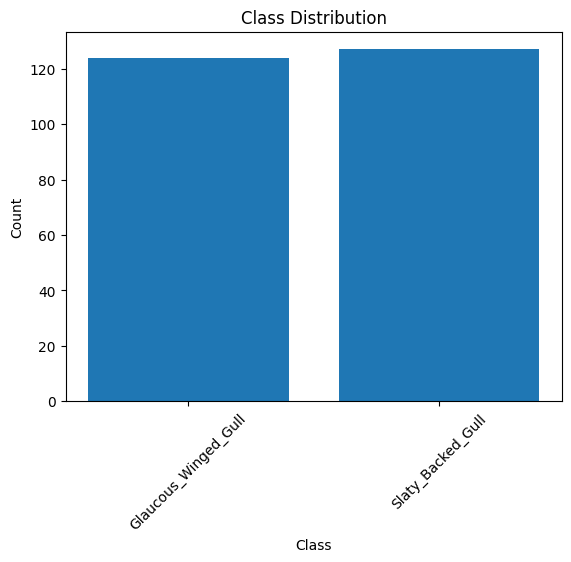

In [4]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from google.colab import drive
drive.mount('/content/drive')


# Define path to dataset and transformation
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'

# Define transformations - to normalize and resize the images
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(data_path, transform=transform)

# Visualize a few images from the dataset to understand the data
def visualize_data(dataset, num_images=6):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(f"Label: {dataset.classes[label]}")
        ax[i].axis('off')
    plt.show()

# Visualize first few images
visualize_data(dataset)

# Analyzing class distribution (data imbalance)
def analyze_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1
    return class_counts

class_distribution = analyze_class_distribution(dataset)
print("Class distribution:", class_distribution)

# Plot class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


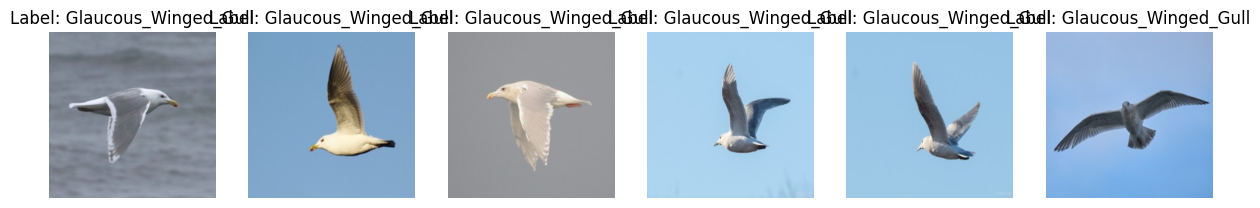

Epoch 1, Loss: 2.3182373046875
Model successfully overfitted on the batch
Predictions: tensor([1, 0, 1, 0])
Actual Labels: tensor([1, 0, 1, 0])
Epoch [1/5], Loss: 2.826359298450989
Epoch [2/5], Loss: 0.6367455730587244
Epoch [3/5], Loss: 0.45814675934612753
Epoch [4/5], Loss: 0.3702223181724548
Epoch [5/5], Loss: 0.21447940550744535
Validation Loss: 0.7139471098780632, Accuracy: 70.58823529411765%


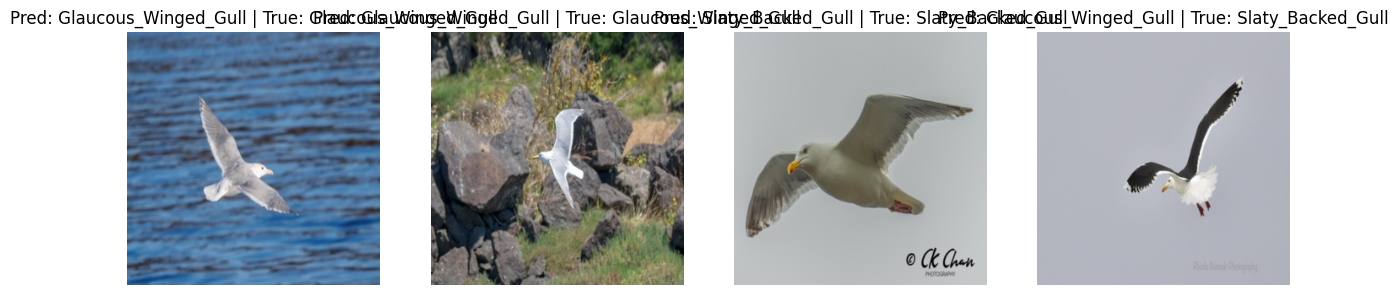

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set seed for reproducibility
torch.manual_seed(42)

# Data preparation (Tip: inspect and preprocess your data)
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'

transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to 300x300 based on dataset specifics
    transforms.ToTensor(),
])

# Load dataset and visualize examples
dataset = datasets.ImageFolder(data_path, transform=transform)

def visualize_data(dataset, num_images=6):
    """ Visualize dataset images """
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(f"Label: {dataset.classes[label]}")
        ax[i].axis('off')
    plt.show()

visualize_data(dataset)

# Split dataset into train/validation sets (Tip: setup early pipeline)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define a simple CNN model (Tip: start with simple models)
class SimpleCNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Conv layer
        self.pool = nn.MaxPool2d(2, 2)               # Pooling layer
        self.fc1 = None                              # Placeholder for FC layer
        self._initialize_fc(input_size)

    def _initialize_fc(self, input_size):
        """ Dynamically calculate FC layer size """
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_size)
            dummy_output = self.pool(torch.relu(self.conv1(dummy_input)))
            flattened_size = dummy_output.view(1, -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))     # Conv -> ReLU -> Pool
        x = x.view(x.size(0), -1)                   # Flatten the tensor
        x = self.fc1(x)                             # Fully connected layer
        return x

# Initialize the model (Tip: start with fixed seed)
input_size = (3, 300, 300)  # Update to match the actual image size
model = SimpleCNN(input_size)

# Define loss and optimizer (Tip: use Adam with a safe LR)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (Tip: instrument code for debugging)
def train(model, loader, criterion, optimizer, epochs=5):
    """ Train the model over the dataset """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader)}")

# Validation loop (Tip: evaluate simple models early on)
def validate(model, loader, criterion):
    """ Validate the model performance """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(loader)}, Accuracy: {accuracy}%')

# Overfit a single batch (Tip: debugging by overfitting a single batch)
single_batch = next(iter(train_loader))

def overfit_single_batch(model, batch, criterion, optimizer, epochs=100):
    """ Overfit on a single batch to detect issues """
    device = torch.device("cpu")
    model.to(device)

    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

        if loss.item() < 0.01:
            print("Model successfully overfitted on the batch")
            break

    # Sanity check after overfitting
    with torch.no_grad():
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        print(f'Predictions: {predicted}')
        print(f'Actual Labels: {labels}')

# Run overfitting on a single batch (Tip: overfit a small batch for early debugging)
overfit_single_batch(model, single_batch, criterion, optimizer)

# Visualize model predictions
def visualize_predictions(model, dataset, batch_size=4):
    """ Visualize model predictions """
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to('cpu'), labels.to('cpu')

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # Visualize images with their predicted and true labels
    fig, ax = plt.subplots(1, batch_size, figsize=(15, 5))
    for i in range(batch_size):
        ax[i].imshow(inputs[i].permute(1, 2, 0))
        ax[i].set_title(f'Pred: {dataset.classes[preds[i]]} | True: {dataset.classes[labels[i]]}')
        ax[i].axis('off')
    plt.show()

# Train and validate the model
train(model, train_loader, criterion, optimizer, epochs=5)
validate(model, val_loader, criterion)

# Visualize predictions
visualize_predictions(model, dataset)
